# Predicting vaccination rates in the US


## Models used:

- `Regularised regression`
- `Random Forest regression`
- `Gradient Boosted Decision Trees`
- `SVM`?
- `NN`?


### Normalisation:

- `Regularised regression`



In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn import preprocessing

In [32]:
base = os.path.split(os.getcwd())[0]
dd = base + '/data/'

In [33]:
df_all = pd.read_csv(dd + 'data_after_imputation.csv')

In [66]:
df_all.shape

(3108, 34)

In [34]:
df_all.columns

Index(['fips', 'state', 'county', 'state_abb', 'pop_full_12plus_per',
       'pop_full_18plus_per', 'pop_full_65plus_per', 'cases_prop',
       'death_prop', 'hesitant_unsure', 'SVI', 'SVI_cat', 'CVAC', 'CVAC_cat',
       'Hispanic (%)', 'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'noHealthInsurance', 'noHighSchool',
       'Poverty', 'logPopDensity', 'Urban_rural_code', 'PrematureDeath',
       'Smoking', 'anycondition_prevalence', 'per_dem', 'per_voted', 'Testing',
       'Traffic', 'DaytimePopDensity', 'ToxPi Score'],
      dtype='object')

<Figure size 2016x1728 with 0 Axes>

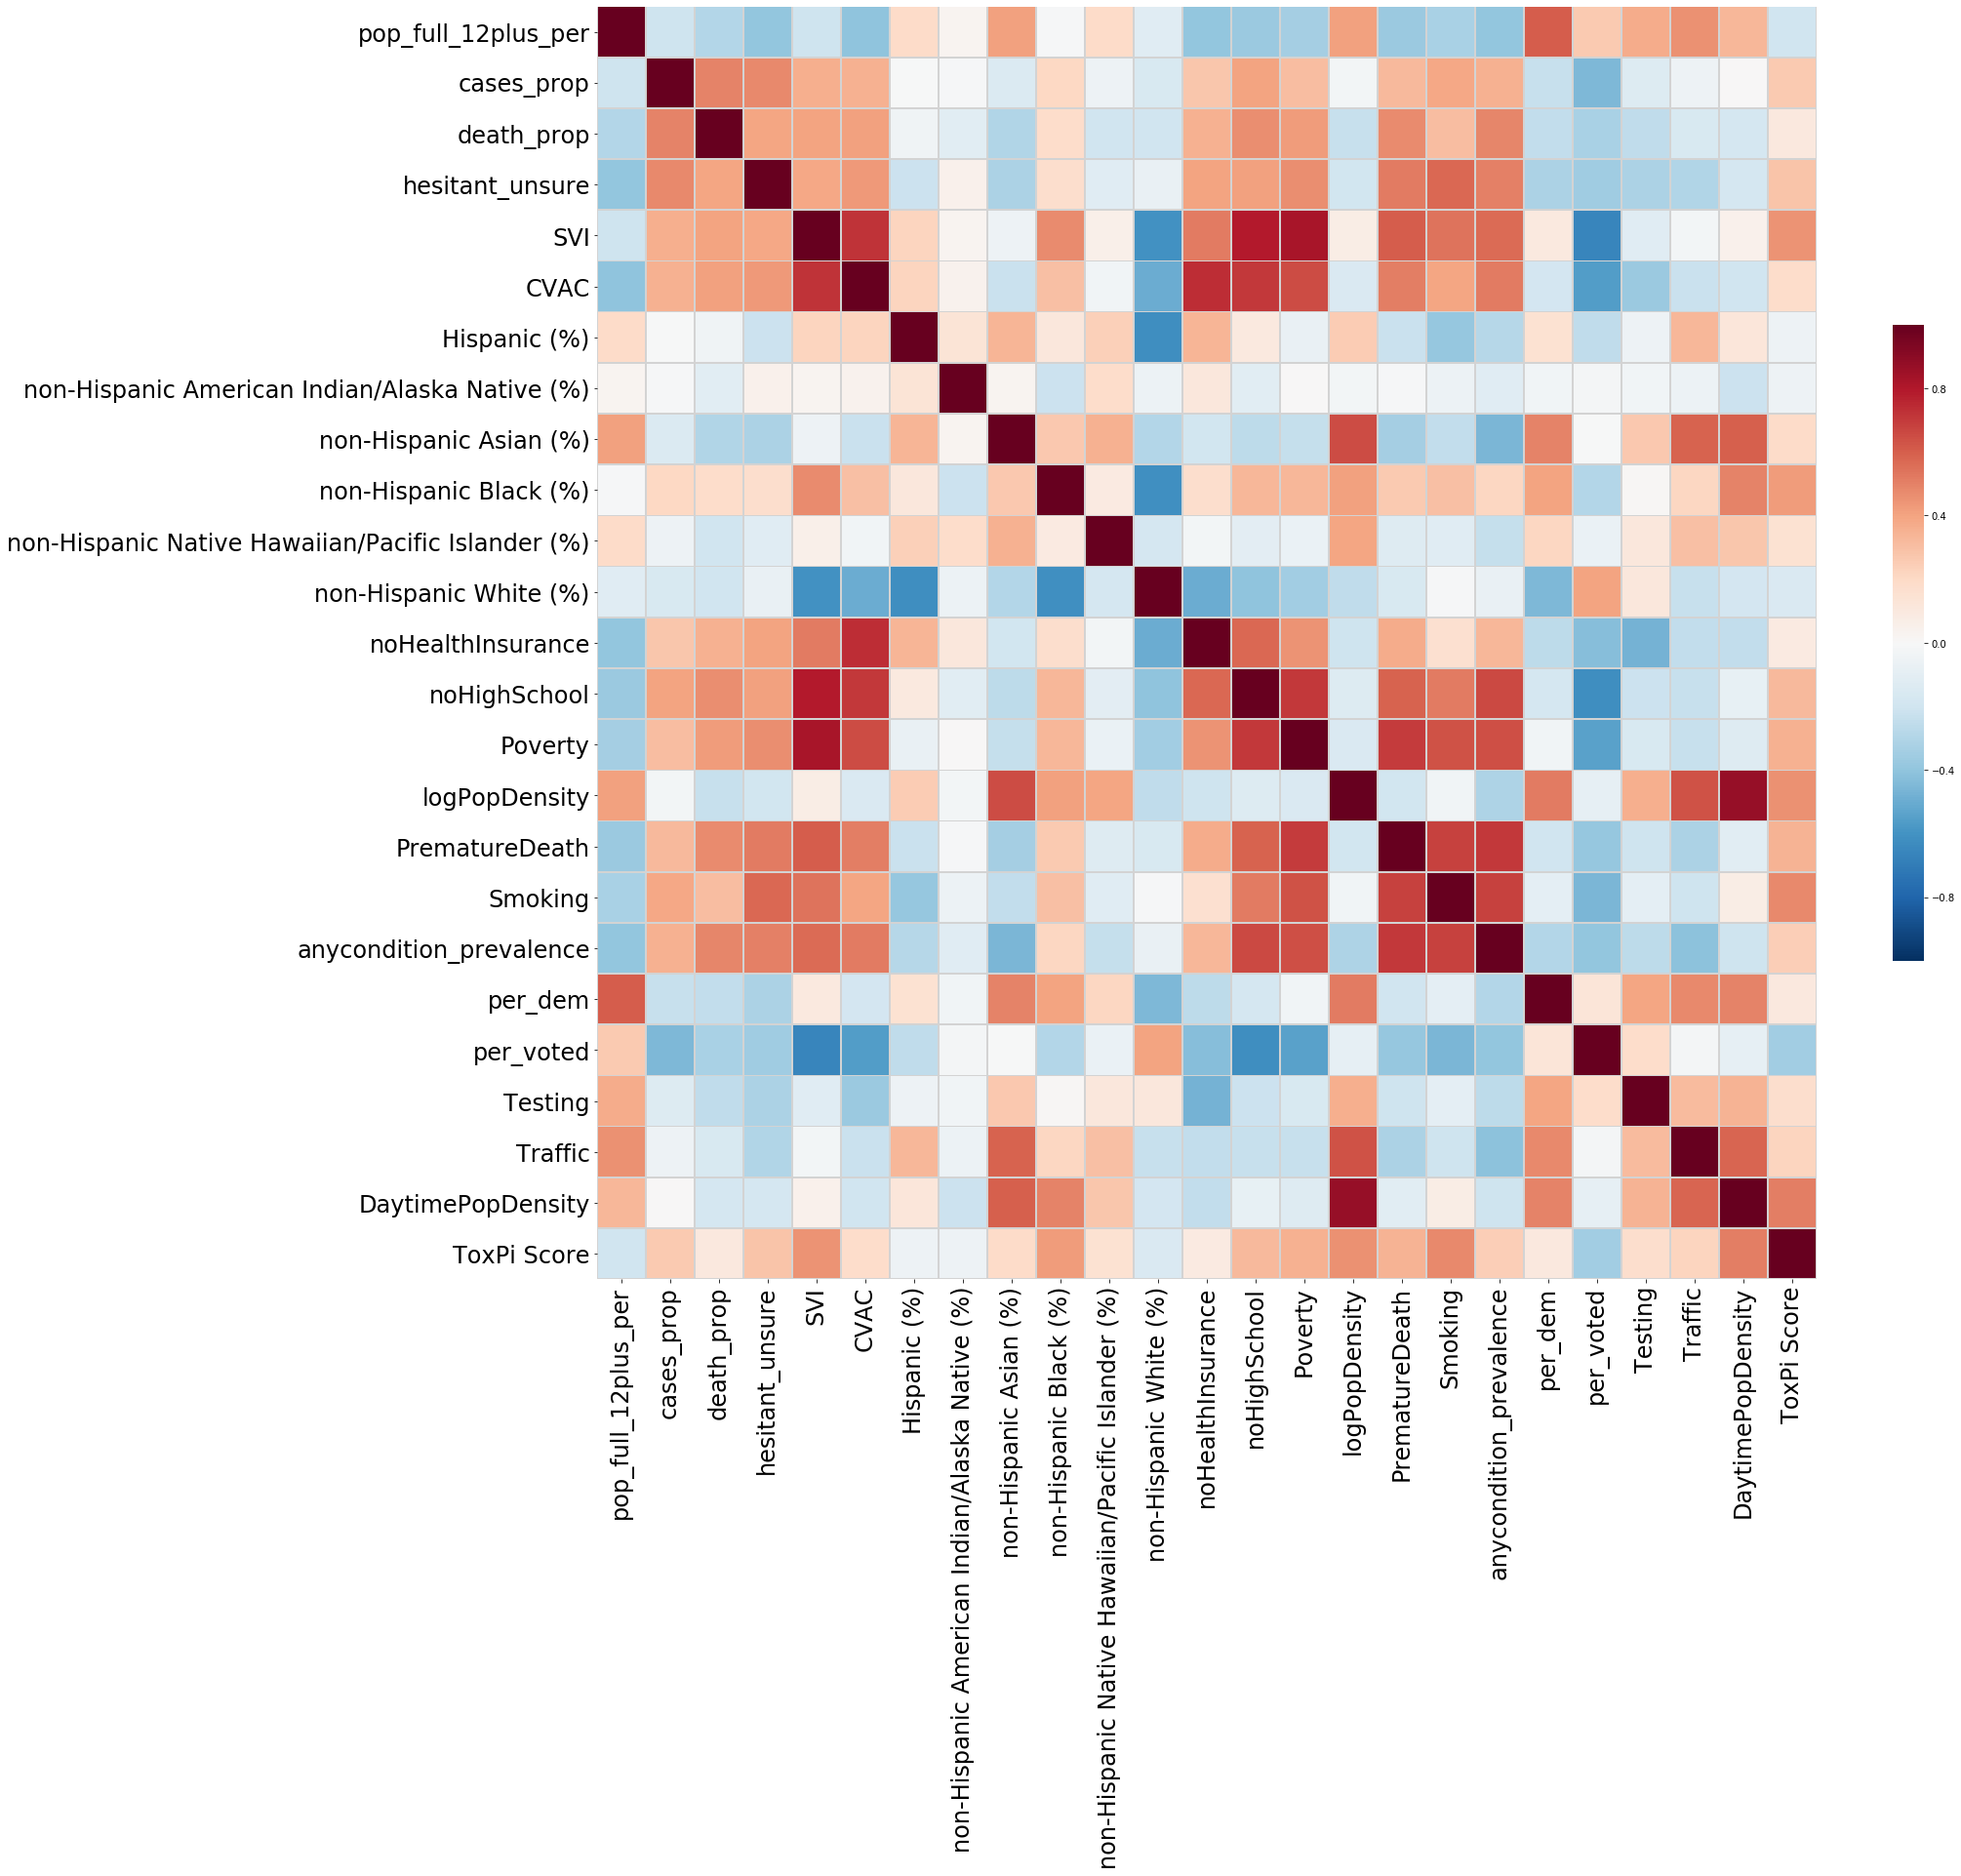

In [36]:
plt.figure(figsize = (28, 24))

full_corr_12 = df_all.select_dtypes(include = ['float64']).drop(columns = ['pop_full_18plus_per',
                               'pop_full_65plus_per']).corr(method = 'spearman')

corr_02 = full_corr_12.where(-((full_corr_12 < 0.2) & (full_corr_12 > -0.2)))

plt.figure(figsize = (28, 24))

color_map = plt.cm.get_cmap('RdBu')
reversed_col = color_map.reversed()

ax = sns.heatmap(full_corr_12, 
                      cmap = reversed_col, linewidths = 0.6,
                      cbar_kws={"shrink": 0.5},
                      vmin = -1, vmax = 1,
                      linecolor = 'lightgrey')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [67]:
df_all.isnull().sum()[df_all.isnull().sum() > 1]

pop_full_12plus_per     55
pop_full_18plus_per    266
pop_full_65plus_per      8
dtype: int64

### Drop `NaN` from target:

In [68]:
df = df_all[df_all['pop_full_12plus_per'].notna()]

In [69]:
df.shape

(3053, 34)

## Split data into `train`, `val` and `test` samples.

- keep `fips` for now to be able to explore, which counties were not well predicted.
- predict `pop_full_12plus_per` for now.


- Discuss: `val` sample? `test_size` = ?
- Note dropping categorical features `SVI_cat` and `CVAC_cat`

In [39]:
y = df['pop_full_12plus_per']
X = df.drop(columns = ['state_abb', 'pop_full_12plus_per',
                       'pop_full_18plus_per', 'pop_full_65plus_per',
                       'SVI_cat', 'CVAC_cat'])

#### `y_test` - leave until final model has been picked.

In [40]:
X_train_val_fips, X_test_fips, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [41]:
print('test data shape:', y_test.shape)

test data shape: (611,)


#### Get a validation sample?

In [42]:
X_train_fips, X_val_fips, y_train, y_val = train_test_split(X_train_val_fips, y_train_val,
                                                           test_size = 0.2, random_state = 42)

In [43]:
print('train data shape:', y_train.shape)
print('val data shape:', y_val.shape)

train data shape: (1953,)
val data shape: (489,)


#### Drop `fips` for modelling

In [44]:
X_test = X_test_fips.drop(columns = ['fips','state', 'county'])
X_train = X_train_fips.drop(columns = ['fips','state', 'county'])
X_val = X_val_fips.drop(columns = ['fips','state', 'county'])

In [45]:
X_train.shape

(1953, 25)

-------
## Individual models:

---------
## Regularised regression:

`Ridge` / `Lasso`

#### To consider:

- outliers
- transfor of rights skewed data
- optimise `lambda`(default = 1; alpha = 0 - OLS). Larger alpha specify stronger regularisation and the coefficients become more robust to collinearity. 

In [46]:
reg = LinearRegression().fit(X_train, y_train)
y_train_reg = reg.predict(X_train)
y_val_reg = reg.predict(X_val)

print('Training score:', reg.score(X_train, y_train))
print('Validation score:', reg.score(X_val, y_val))

Training score: 0.6125597475567847
Validation score: 0.4814153435337112


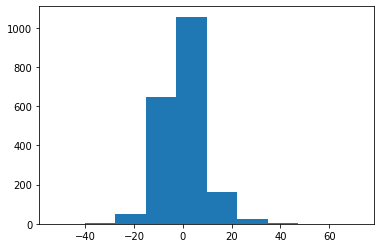

In [48]:
residuals = y_train_reg - y_train
plt.hist(residuals)
plt.show()

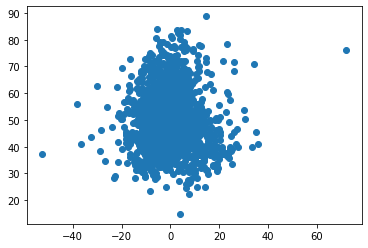

In [49]:
plt.scatter(residuals, y_train_reg)
plt.show()

## Ridge Regression:

In [51]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [52]:
rid = Ridge(alpha = 1).fit(X_train_scaled, y_train)
y_train_rid = reg.predict(X_train_scaled)
y_val_rid = reg.predict(X_val_scaled)

print('Training score:', rid.score(X_train_scaled, y_train))
print('Validation score:', rid.score(X_val_scaled, y_val))

Training score: 0.6125568024446155
Validation score: 0.48146470588828544


----------
## Random Forest Regression:

- No scaling of the data.
- RF might be trickier when combining categorical and continuous data, as RF will give more weight to continuous features especially in calculating the feature_importances. RF is likely to give more weight to parameters with more levels.

- optimise 
    - `n_estimators` (number of random trees), 
    - `max_features` (the number of randomly selected features in each tree, if max_features is close to the total number of features, the trees are more likely to be similar.
    - `max_depth` – the depth of each tree in the ensemble (default=None, splits until all leaves are pure).


#### Train base model prior to optimising Ho:


- overfitting! `RF_base rho: 0.964`

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF_base rho: 0.961
R2 score: 0.925
MAE: 2.610



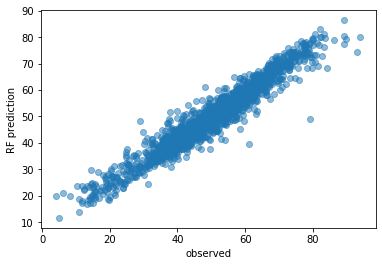

In [53]:
rf_base = RandomForestRegressor()

rf_base.fit(X_train, y_train)
y_train_rf_base = rf_base.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_rf_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_rf_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_rf_base)))
print()
plt.scatter(y_train,y_train_rf_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

### Feature importance:

In [54]:
feature_names = X_train.columns

importances = rf_base.feature_importances_

std = np.std([
    tree.feature_importances_ for tree in rf_base.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)

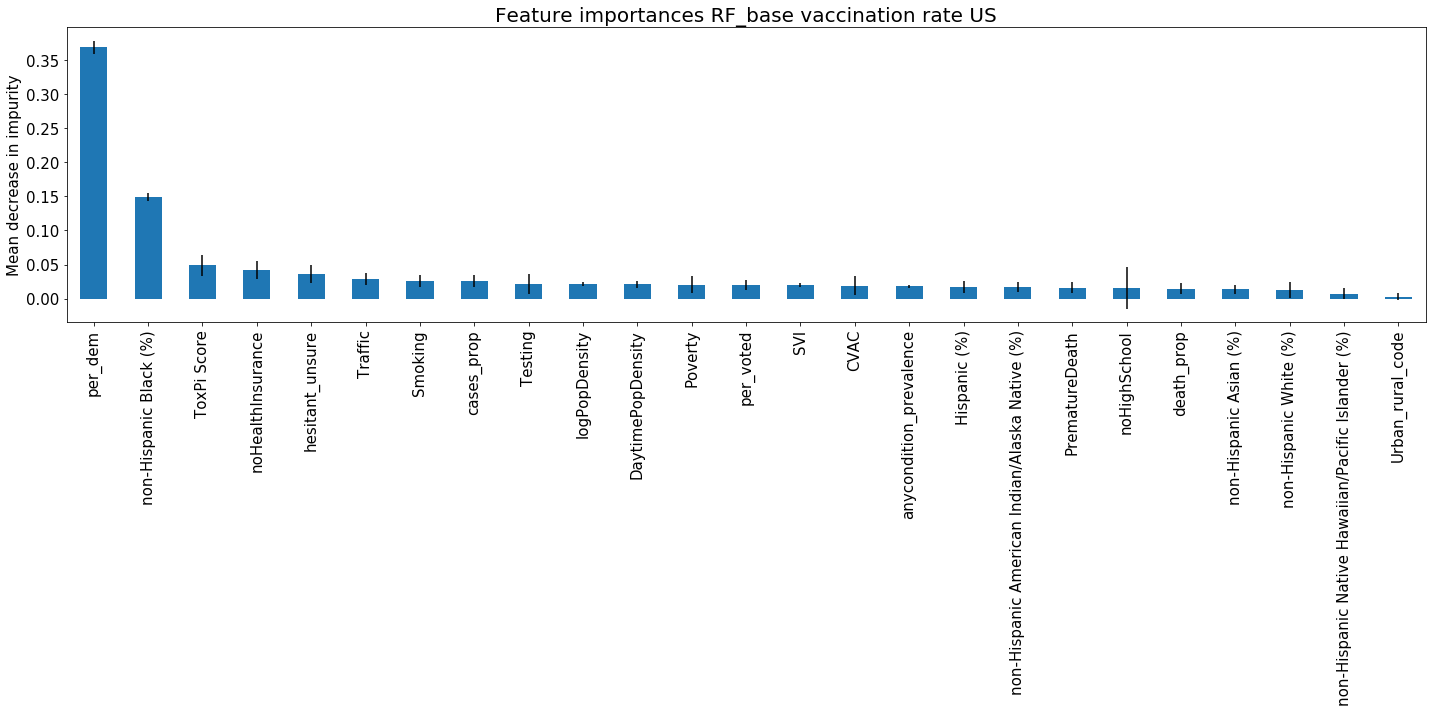

In [55]:

fig, ax = plt.subplots(figsize = (20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances RF_base vaccination rate US" , fontsize=20)

ax.set_ylabel("Mean decrease in impurity", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize = 15)

fig.tight_layout()

from sklearn.inspection import permutation_importance

result = permutation_importance(rf_base, X_train, y_train, n_repeats=5,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Hyperparam optimisation:

In [56]:
search_param = {'n_estimators': [10, 100, 500, 1000],
               'max_features':('auto', 'sqrt'),
               'max_depth': [5, 15, 20, 25]}

search = GridSearchCV(rf_base, param_grid = search_param,
                     cv = 5, scoring = 'neg_mean_absolute_error')

search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 15, 20, 50],
     

In [57]:
print(search.best_params_)
print(search.best_score_)

{'max_depth': 50, 'max_features': 'auto', 'n_estimators': 500}
-6.05104895033282


### Updated RandomForest:

####  `GridSearchCV` takes ~15 min to run so results are saved below:

massively overfitting still.

RF_base rho: 0.981
R2 score: 0.949
MAE: 2.207



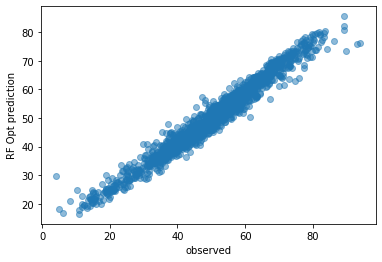

In [58]:
rf_opt = RandomForestRegressor(n_estimators = 500, max_features = 'auto', max_depth = 20)

rf_opt.fit(X_train, y_train)
y_train_rf_opt = rf_opt.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_rf_opt)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_rf_opt)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_rf_opt)))
print()
plt.scatter(y_train,y_train_rf_opt, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF Opt prediction')
plt.show()

### Validation set:

`rf_base` vs `rf_opt`

Rho: Base 0.769607, Opt 0.783472
MAE: Base 6.663620, Opt 6.221799
R2: Base 0.560249, Opt 0.577486


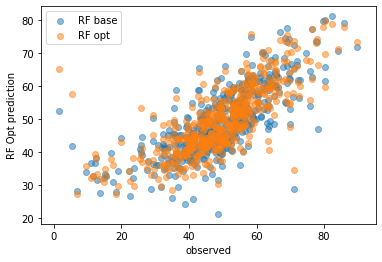

In [59]:
y_val_rf_base = rf_base.predict(X_val)
y_val_rf_opt = rf_opt.predict(X_val)


print('Rho: Base {:2f}, Opt {:2f}'.format(spearmanr(y_val,y_val_rf_base)[0],
                                     spearmanr(y_val,y_val_rf_opt)[0]))
print('MAE: Base {:2f}, Opt {:2f}'.format(mean_absolute_error(y_val,y_val_rf_base),
                                     mean_absolute_error(y_val,y_val_rf_opt)))
print('R2: Base {:2f}, Opt {:2f}'.format(r2_score(y_val,y_val_rf_base),
                                     r2_score(y_val,y_val_rf_opt)))

plt.scatter(y_val,y_val_rf_base, alpha = 0.5, label = 'RF base')
plt.scatter(y_val,y_val_rf_opt, alpha = 0.5, label = 'RF opt')
plt.xlabel('observed'), plt.ylabel('RF Opt prediction')
plt.legend()
plt.show()

### Explore counties with large errors:

#### abs(`obs` - `pred`) > 20

In [60]:
d = {'obs': y_val.values,
    'pred': y_val_rf_opt}
x_val_rf_pred = pd.DataFrame(data = d)
x_val_rf_pred['error'] = x_val_rf_pred['obs'] - x_val_rf_pred['pred']

In [61]:
X_val_fips_error = pd.concat( [X_val_fips.reset_index(drop = True), x_val_rf_pred.reset_index(drop = True)], axis=1)
X_val_fips_error.head(n = 3)

,fips,state,county,cases_prop,death_prop,hesitant_unsure,SVI,CVAC,Hispanic (%),non-Hispanic American Indian/Alaska Native (%),...,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
0,26001,Michigan,Alcona County,9.053340,0.374820,0.1717,0.26,0.37,0.0150,0.0058,...,50.5,0.303228,0.678904,2249.0,12.143237,13.1,0.447609,55.1,52.051297,3.048703
1,9009,Connecticut,New Haven County,12.019790,0.259021,0.0854,0.52,0.04,0.1811,0.0010,...,39.5,0.580480,0.489004,4697.0,550.060850,1362.4,0.461122,77.5,73.222780,4.277220
2,29043,Missouri,Christian County,14.269428,0.173825,0.1946,0.15,0.45,0.0295,0.0030,...,44.7,0.237644,0.528687,1831.0,65.429545,117.6,0.430476,48.6,49.923418,-1.323418


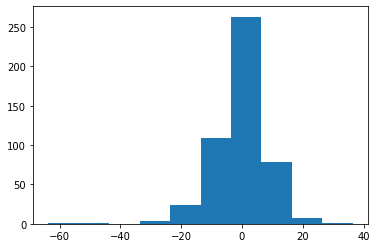

In [62]:
plt.hist(X_val_fips_error['error'])
plt.show()

In [63]:
X_val_fips_error[abs(X_val_fips_error['error']) > 20]

,fips,state,county,cases_prop,death_prop,hesitant_unsure,SVI,CVAC,Hispanic (%),non-Hispanic American Indian/Alaska Native (%),...,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
3,42053,Pennsylvania,Forest County,21.222575,0.317373,0.1849,0.71,0.54,0.0554,0.0004,...,49.3,0.275132,0.365117,4429.0,22.080382,14.2,0.443240,71.2,34.769600,36.430400
104,46089,South Dakota,McPherson County,12.694409,0.294241,0.1485,0.29,0.12,0.0131,0.0035,...,44.8,0.167674,0.556536,1093.0,6.134701,2.1,0.477249,12.5,38.304138,-25.804138
137,25001,Massachusetts,Barnstable County,7.902249,0.238039,0.0612,0.06,0.00,0.0310,0.0057,...,37.9,0.611967,0.705784,3690.0,65.380735,532.5,0.499337,5.5,57.643000,-52.143000
145,50005,Vermont,Caledonia County,4.947821,0.033341,0.0939,0.27,0.31,0.0160,0.0030,...,36.9,0.557301,0.539092,8242.0,52.297211,47.5,0.488079,36.1,56.360900,-20.260900
149,54105,West Virginia,Wirt County,12.867205,0.171792,0.1524,0.37,0.44,0.0047,0.0000,...,59.3,0.175650,0.455764,5566.0,0.065980,18.2,0.555453,6.7,27.466200,-20.766200
165,13187,Georgia,Lumpkin County,13.823267,0.270753,0.2076,0.43,0.65,0.0484,0.0022,...,41.2,0.201275,0.462095,1119.0,44.623691,102.6,0.542525,10.9,32.182884,-21.282884
211,13049,Georgia,Charlton County,16.039427,0.388292,0.2723,0.88,0.95,0.0837,0.0178,...,51.4,0.241900,0.341099,680.0,27.798933,12.1,0.554278,12.9,33.492939,-20.592939
217,25019,Massachusetts,Nantucket County,8.949593,0.145995,0.0603,0.03,0.01,0.0416,0.0029,...,32.8,0.717356,0.640933,3123.0,0.000000,236.8,0.379504,1.5,65.146400,-63.646400
258,28063,Mississippi,Jefferson County,13.319027,0.472103,0.2810,0.96,0.97,0.0722,0.0015,...,64.3,0.850678,0.559514,2389.0,13.027174,13.7,0.493065,69.8,47.618000,22.182000
277,13055,Georgia,Chattooga County,17.681230,0.367098,0.2414,0.93,0.92,0.0515,0.0014,...,53.5,0.184478,0.405422,1763.0,63.186996,73.0,0.632376,15.0,35.061610,-20.061610


In [64]:
X_val_fips_error[abs(X_val_fips_error['error']) > 60]

,fips,state,county,cases_prop,death_prop,hesitant_unsure,SVI,CVAC,Hispanic (%),non-Hispanic American Indian/Alaska Native (%),...,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
217,25019,Massachusetts,Nantucket County,8.949593,0.145995,0.0603,0.03,0.01,0.0416,0.0029,...,32.8,0.717356,0.640933,3123.0,0.0,236.8,0.379504,1.5,65.1464,-63.6464


In [65]:
df_all[df_all['fips'] == 25019]

,fips,state,county,state_abb,pop_full_12plus_per,pop_full_18plus_per,pop_full_65plus_per,cases_prop,death_prop,hesitant_unsure,...,Urban_rural_code,PrematureDeath,Smoking,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score
1192,25019,Massachusetts,Nantucket County,MA,1.5,1.6,2.9,8.949593,0.145995,0.0603,...,6,4173.372859,0.139488,32.8,0.717356,0.640933,3123.0,0.0,236.8,0.379504


-----------------
## ExtraTreesRegressor

RF_base rho: 1.000
R2 score: 1.000
MAE: 0.000



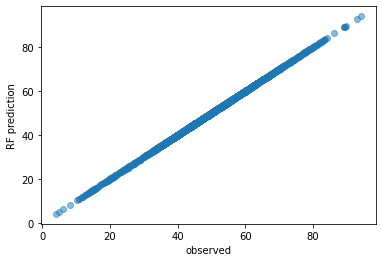

In [36]:
etr_base = ExtraTreesRegressor()

etr_base.fit(X_train, y_train)
y_train_etr_base = etr_base.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_etr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_etr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_etr_base)))
print()
plt.scatter(y_train,y_train_etr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

RF_base rho: 0.798
R2 score: 0.605
MAE: 6.028



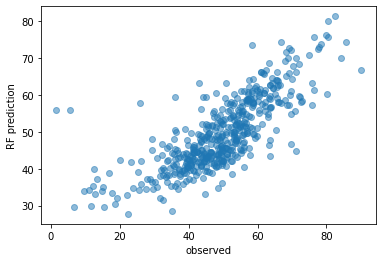

In [40]:
etr_base.fit(X_train, y_train)
y_val_etr_base = etr_base.predict(X_val)

print('RF_base rho: {:.3f}'.format(spearmanr(y_val,y_val_etr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_val,y_val_etr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_val,y_val_etr_base)))
print()
plt.scatter(y_val,y_val_etr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

RF_base rho: 0.950
R2 score: 0.910
MAE: 3.199



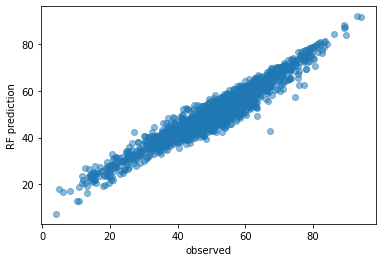

In [39]:
etr_base = ExtraTreesRegressor(max_depth = 10)

etr_base.fit(X_train, y_train)
y_train_etr_base = etr_base.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_etr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_etr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_etr_base)))
print()
plt.scatter(y_train,y_train_etr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

RF_base rho: 0.797
R2 score: 0.598
MAE: 6.058



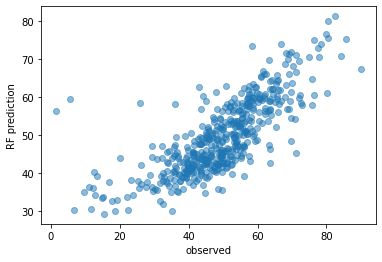

In [41]:
etr_base = ExtraTreesRegressor(max_depth = 10)

etr_base.fit(X_train, y_train)
y_val_etr_base = etr_base.predict(X_val)

print('RF_base rho: {:.3f}'.format(spearmanr(y_val,y_val_etr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_val,y_val_etr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_val,y_val_etr_base)))
print()
plt.scatter(y_val,y_val_etr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

## AdaBoostRegressor

In [ ]:
etr_base = AdaBoostRegressor()

etr_base.fit(X_train, y_train)
y_train_etr_base = etr_base.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_etr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_etr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_etr_base)))
print()
plt.scatter(y_train,y_train_etr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()